## AWS AI Service :

Forecast Open API Service Features

* Upload the data file to ./cloudmesh/upload-file location
* Upload the json schema file to ./cloudmesh/upload-file location
* Validate the data for missing and less than 0 values
* Split the dataset into Train and test by specifying split percentge.
* Provide list of Multi Cloud supported for Timeseries Forecasting
* Initialize the cloud service
* Create a Dataset Group, a Target Time Series Dataset, Import data into Forecast from AWS Storage S3,  Create a Predictor, Generate Forecast
* Query the Forecast
* Compare Forecast

### Pre-requsites

Ensure requirements listed at are met before starting the experiment https://github.com/cloudmesh-community/sp20-516-255/blob/master/Cloudmesh-OpenAPI/README.md

Once environment is available, execute below API commands and in order mentioned in the notebook.

####  List the Time Series forecasting services supported

In [161]:
!curl --silent http://localhost:8080/cloudmesh/forecast

{
  "model": "Supported Time Series Forecast Services AWS : Forecast "
}


!curl http://localhost:8080/cloudmesh/forecast

####  Upload the data file to be forecasted

In [166]:
!curl --silent --show-error "http://localhost:8080/cloudmesh/forecast/upload" -F "upload=@C:\\Users\\prafu\\data\\time_series_combined.csv"

time_series_combined.csv uploaded successfully


####  Upload the JSON Schema for the data, ensure three mandatory columns 

* item_id ( column for which prediction need to be generated)
* target_value ( the atrribute that need to be predicted) 
* timestamp (date or time in timstamp format)

In [168]:
!curl --silent --show-error "http://localhost:8080/cloudmesh/forecast/upload" -F "upload=@C:\\Users\\prafu\\data\\schema.json"

schema.json uploaded successfully


#### Validate the data file

In [169]:
!curl --silent --show-error "http://localhost:8080/cloudmesh/forecast/validate_data" -F "upload=@C:\\Users\\prafu\\.cloudmesh\\upload-file\\time_series_combined.csv"

time_series_combined.csv validated successfully


#### Split data 

Split the data into training and validation dataset. Forecast service predictor will further subdivide the dataset into test and training based on BackTestWindowOffset. Please refer [Predictor Performance](https://docs.aws.amazon.com/forecast/latest/dg/metrics.html) for more details.

In [172]:
!curl --silent --show-error http://localhost:8080/cloudmesh/forecast/split_data?split_pct=30

"Data split successfully"


####  Initialize the cloud service

In [174]:
!curl --silent --show-error "http://localhost:8080/cloudmesh/forecast/aws"

{
  "model": "AWS AI Service initialized successfully"
}


#### Step7 - Generate the Forecast

In [32]:
!curl --silent --show-error http://localhost:8080/cloudmesh/forecast/create_forecast?country=Spain

"Forecast generated successfully"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:07 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:08 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:09 --:--:--     0
  0     0    0     0    0     0      0      0 --:--

####  Look up the forecast 

countryName parameter should be the item_id to be predicted.

In [175]:
!curl --silent --show-error http://localhost:8080/cloudmesh/forecast/lookupForecast?countryName=Spain

"Execute create forecast first"


#### Compare Actual Results Vs Forecast Predicted Results 

* Import the test data created as part of split
* Update the columns as per schema.json uploaded

In [140]:
import pandas as pd

test_df = pd.read_csv("aiservices-test.csv", names=['timestamp','item_id','confirmed', 'target_value', 'deaths'])
test_df.head()

,timestamp,item_id,confirmed,target_value,deaths
0,2020-03-16 00:00:00,Tunisia,20.0,0,0.0
1,2020-03-29 00:00:00,Oman,167.0,23,0.0
2,2020-03-20 00:00:00,Latvia,111.0,1,0.0
3,2020-02-21 00:00:00,Israel,1.0,0,0.0
4,2020-02-08 00:00:00,China,195.0,20,0.0


In [150]:
fromdate='2020-04-14'
todate='2020-06-12'

In [151]:
test_df = test_df[(test_df['timestamp'] >= fromdate) & (test_df['timestamp'] < todate)]

Provide the item for which the forecast need to be looked at in !curl http://localhost:8080/cloudmesh/forecast/lookupForecast?countryName=India 

In [152]:
lookupitem='India'

In [153]:
test_df = test_df[(test_df['item_id'] == lookupitem)]
test_df.head()

,timestamp,item_id,confirmed,target_value,deaths
8073,2020-05-06 00:00:00,India,52987.0,15331,1785.0
17274,2020-05-07 00:00:00,India,56351.0,16776,1889.0


Plot actual data points selected.

In [154]:
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecast_arn,
    Filters={"item_id":"Spain"}
)

#### Generate predictions

Generate 10, 50 and 90 percentile predictions and merge it into a results data frame

In [176]:
pred_p10 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p10'])
pred_p50 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p50'])
pred_p90 = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p90'])

In [155]:
pred_p10['value'] = pred_p10['Value'].astype(int)
pred_p50['value'] = pred_p50['Value'].astype(int)
pred_p90['value'] = pred_p90['Value'].astype(int)

In [178]:
pred_df = pd.DataFrame(columns=['timestamp', 'Value', 'source'])

In [179]:
for index, row in pred_p10.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    pred_df = pred_df.append({'timestamp' : clean_timestamp , 'Value' : row['Value'], 'source': 'p10'} , ignore_index=True)
for index, row in prediction_df_p50.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    pred_df = pred_df.append({'timestamp' : clean_timestamp , 'Value' : row['Value'], 'source': 'p50'} , ignore_index=True)
for index, row in prediction_df_p90.iterrows():
    clean_timestamp = dateutil.parser.parse(row['Timestamp'])
    pred_df = pred_df.append({'timestamp' : clean_timestamp , 'Value' : row['Value'], 'source': 'p90'} , ignore_index=True)

Generate plot for actual and predicted data.

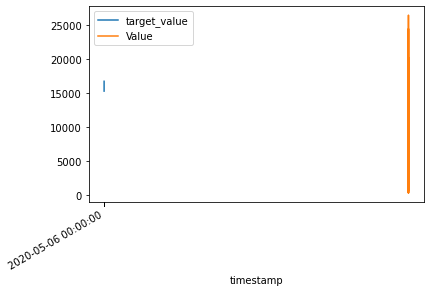

In [180]:
ax = test_df.plot(x='timestamp', y='target_value')
results_df.plot(ax=ax, x='timestamp', y='Value')